In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# This notebook offers
## Hyperparameter Search, Training & Saving  + Loading & Testing CNN models

### Main instructions

- Global settings section
    - Set hyperparameter search flag (takes a while). If one wants to check how it runs, see the below section on how to set up a smaller search grid
    - Set the dataset to one of the two options
    - Set the experiment type: deep or shallow refers to the number of layers in the model (and concretely correspond to the "grid_params" variable in the Hyperparameter Search section
    - Otherwise, just run all notebook cells and check outputs of sections of interest.
    
### Detailed instructions for each section
  
- Hyperparameter search section
    - This takes long, so one could skip directly to the next step (or set a small number of search iterations)
    - The number of configs to be tested (number of search iterations) is set via the "n_iter" argument to "RandomizedSearchCV"
    - Set the hyperparameter search grid via the "grid_params" variable
    - By default, we use 4 splits for both the outer loop ("cv" argument to "RandomizedSearchCV") and the inner ("train_split" argument in "get_neural_net_classifier")
    

- Train & Save section
    - use the best parameters found by the hyperparameter search, or just set custom ones
    - this trains with a more patient early stopping, and saves the best model according to validation loss
    
    
- Load back model and evaluate
    - will work only if a model was previously trained and saved



# Global Settings

In [2]:
DO_HYPERPARAMETER_SEARCH = True

# DATASET = "MITBIH"
DATASET = "PTBDB"

# EXPERIMENT_TYPE = "shallow_hyperparam_search"
EXPERIMENT_TYPE = "deep_hyperparam_search"
MODEL_SAVE_DIR = EXPERIMENT_TYPE + '_' + DATASET

if DATASET == "MITBIH":
    N_CLASSES = 5
else:
    N_CLASSES = 2
    

# Imports

In [3]:
import os

import numpy as np
import pandas as pd

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, Checkpoint, EarlyStopping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import RandomizedSearchCV

from src.metrics_utils import compute_metrics, skorch_f1_score, sklearn_f1_score
from src.data_loading import load_data_mitbih, load_data_ptbdb
from src.data_preprocessing import preprocess_x_pytorch, preprocess_y_pytorch
from src.cnn_models.cnn import CNN
from src.skorch_utils import get_neural_net_classifier, get_class_weights
from src.json_utils import save_file, read_file, serialize_tensors, deserialize_tensors

torch.manual_seed(0)
np.random.seed(0)


# Data Loading and Preprocessing

In [4]:
if N_CLASSES == 5:
    (x, y), (xtest, ytest) = load_data_mitbih()
else:
    (x, y), (xtest, ytest) = load_data_ptbdb()
    
print(x.shape)
print(np.unique(y))
assert np.array_equal(np.unique(y), np.unique(ytest))


(11641, 187, 1)
[0 1]


In [5]:
x, xtest = preprocess_x_pytorch(x), preprocess_x_pytorch(xtest)
y, ytest = preprocess_y_pytorch(y), preprocess_y_pytorch(ytest)


# Hyperparameter Search

In [6]:
lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              min_lr=0.000001,
                              patience=2,
                              verbose=True)

early_stopping_cb = EarlyStopping(patience=8, monitor="skorch_f1_score", lower_is_better=False)
macro_f1_cb = skorch.callbacks.EpochScoring(scoring=skorch_f1_score, lower_is_better=False)


In [7]:
if DO_HYPERPARAMETER_SEARCH:
    
    # Add the class weights as a grid parameter -> bool value to indicate if weights are balanced or not
    net = get_neural_net_classifier(module=CNN, n_classes=N_CLASSES, 
                                    callbacks=[macro_f1_cb, lr_scheduler_cb, early_stopping_cb],
                                    train_split=4)

    
    shallow_grid_params = {
        'module__n_filters': [[16, 32], [32, 64], [64, 128]],
        'module__kernel_sizes': [[7, 3], [9, 5], [13, 7]],
        'module__strides': [[2, 2], [2, 1]],
        'module__fully_connected_features': [64, 128, 256],
        'module__adaptive_average_len': [8, 16],
        'module__residual': [True, False],
        
        'criterion__weight': [get_class_weights(y, unbalanced=True), get_class_weights(y)],
        
        'lr': [0.0008, 0.0002],
        'iterator_train__batch_size': [256],
    }
    
    deep_grid_params = {
        'module__n_filters': [[16, 24, 24, 24, 32], [32, 48, 48, 48, 64], [64, 96, 96, 96, 128]],
        'module__kernel_sizes': [[7, 5, 5, 5, 3], [9, 7, 7, 7, 5], [13, 9, 9, 9, 7]],
        'module__strides': [[2, 2, 1, 1, 1], [2, 1, 1, 1, 1]],
        'module__fully_connected_features': [64, 128, 256],
        'module__adaptive_average_len': [8, 16],
        'module__residual': [True, False],
        
        'criterion__weight': [get_class_weights(y, unbalanced=True), get_class_weights(y)],
        
        'lr': [0.0008, 0.0002],
        'iterator_train__batch_size': [256],
    }
    
    if EXPERIMENT_TYPE == "shallow_hyperparam_search":
        grid_params = shallow_grid_params
    elif EXPERIMENT_TYPE == "deep_hyperparam_search":
        grid_params = deep_grid_params
    
    save_file(MODEL_SAVE_DIR + '/grid.json', serialize_tensors(grid_params))

    # outer split k = 4
    gs = RandomizedSearchCV(net, grid_params, n_iter=25, cv=4, scoring={"accuracy": "accuracy", "f1_score": sklearn_f1_score()}, refit="f1_score", verbose=10)

    gs.fit(x, y)
    print(f"\n\nBest score and param setup: {gs.best_score_}, {gs.best_params_}\n\n")

    hyper_search_history = pd.DataFrame(gs.cv_results_)
    hyper_search_history.to_csv(MODEL_SAVE_DIR + '/hyperparam_search_history.csv')


Fitting 4 folds for each of 25 candidates, totalling 100 fits
[CV 1/4; 1/25] START criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0008, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[32, 48, 48, 48, 64], module__residual=False, module__strides=[2, 1, 1, 1, 1]
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4199        0.3981       0.7238        0.9365  0.8272
      2             0.8744        0.1851       0.8992        0.2298  0.6271
      3             0.9415        0.1066       0.9510        0.1227  0.6257
      4             0.9579        0.0630       0.9656        0.0795  0.6224
      5             0.8396        0.0536       0.8891        0.4704  0.6462
      6             0.9847        0.0470       0.9876        0.0426  0.6291
      7             0.9666

      2             0.9038        0.1601       0.9217        0.2031  0.6176
      3             0.9285        0.0907       0.9414        0.1623  0.6167
      4             0.9581        0.0751       0.9670        0.0816  0.6167
      5             0.9753        0.0496       0.9808        0.0640  0.6167
      6             0.9842        0.0312       0.9876        0.0440  0.6162
      7             0.9197        0.0329       0.9404        0.2479  0.6170
      8             0.9803        0.0245       0.9844        0.0461  0.6165
      9             0.9632        0.0214       0.9702        0.1085  0.6164
     10             0.9526        0.0580       0.9620        0.1375  0.6162
     11             0.9824        0.0340       0.9863        0.0587  0.6178
     12             0.9665        0.0162       0.9743        0.1008  0.6158
     13             0.9771        0.0082       0.9817        0.0654  0.6178
     14             0.9907        0.0033       0.9927        0.0329  0.6170
     15     

      7             0.9756        0.0144       0.9808        0.0514  0.5700
      8             0.9798        0.0094       0.9840        0.0540  0.5677
      9             0.9838        0.0075       0.9872        0.0383  0.5685
     10             0.9690        0.0079       0.9757        0.0837  0.5714
     11             0.9762        0.0089       0.9808        0.0640  0.5707
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
     12             0.9685        0.0118       0.9753        0.0884  0.5677
     13             0.9840        0.0046       0.9872        0.0425  0.5702
     14             0.9840        0.0022       0.9872        0.0386  0.5681
     15             0.9851        0.0015       0.9881        0.0382  0.5732
     16             0.9851        0.0012       0.9881        0.0376  0.5684
     17             0.9851        0.0009       0.9881        0.0370  0.5695
     18             0.9857        0.0008       0.9885        0.0365  0.5675
     19             0.9856

     18             0.9854        0.0009       0.9885        0.0495  0.5695
     19             0.9854        0.0009       0.9885        0.0501  0.5678
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 3/4; 2/25] END criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=256, module__kernel_sizes=[13, 9, 9, 9, 7], module__n_filters=[32, 48, 48, 48, 64], module__residual=True, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.987) f1_score: (test=0.984) total time=  11.5s
[CV 4/4; 2/25] START criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=256, module__kernel_sizes=[13, 9, 9, 9, 7], module__n_filters=[32, 48, 48, 48, 64], module__residual=True, module__strides=[2, 2, 1, 1, 1]
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  --

     15             0.9735        0.0435       0.9794        0.0762  0.4828
     16             0.9640        0.0304       0.9711        0.0833  0.4672
     17             0.9736        0.0271       0.9794        0.0723  0.4865
     18             0.9717        0.0179       0.9776        0.0813  0.4692
     19             0.9774        0.0127       0.9821        0.0662  0.4776
     20             0.9771        0.0099       0.9821        0.0706  0.4704
     21             0.9755        0.0099       0.9808        0.0696  0.4794
     22             0.9766        0.0081       0.9817        0.0718  0.4560
     23             0.9724        0.0064       0.9780        0.0809  0.4488
     24             0.9774        0.0042       0.9821        0.0703  0.4481
     25             0.9757        0.0030       0.9808        0.0749  0.4512
     26             0.9740        0.0036       0.9794        0.0821  0.4498
     27             0.9790        0.0060       0.9835        0.0779  0.4502
Epoch 00028:

      8             0.9681        0.0452       0.9748        0.0730  0.4618
      9             0.9701        0.0372       0.9766        0.0712  0.4576
     10             0.9725        0.0273       0.9785        0.0632  0.4553
     11             0.9743        0.0237       0.9798        0.0661  0.4700
     12             0.9716        0.0167       0.9776        0.0659  0.4686
     13             0.9790        0.0124       0.9835        0.0617  0.4483
     14             0.9778        0.0076       0.9826        0.0626  0.4475
     15             0.9756        0.0061       0.9808        0.0640  0.4530
     16             0.9784        0.0037       0.9831        0.0662  0.4482
     17             0.9784        0.0035       0.9831        0.0640  0.4494
     18             0.9777        0.0023       0.9826        0.0653  0.4546
     19             0.9796        0.0017       0.9840        0.0653  0.4501
     20             0.9713        0.0039       0.9776        0.0801  0.4485
     21     

Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 2/4; 4/25] END criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[7, 5, 5, 5, 3], module__n_filters=[64, 96, 96, 96, 128], module__residual=False, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.989) f1_score: (test=0.987) total time=  20.3s
[CV 3/4; 4/25] START criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[7, 5, 5, 5, 3], module__n_filters=[64, 96, 96, 96, 128], module__residual=False, module__strides=[2, 2, 1, 1, 1]
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4219        0.4078       0.7297        0.5722  0.7508
      2             0.8848  

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4185        0.4217       0.7197        0.6959  0.7169
      2             0.7135        0.2029       0.8227        0.5779  0.7171
      3             0.9112        0.1379       0.9317        0.2143  0.7186
      4             0.9147        0.0987       0.9350        0.1776  0.7179
      5             0.9694        0.0677       0.9753        0.0599  0.7180
      6             0.9715        0.0388       0.9771        0.0716  0.7176
      7             0.8827        0.0339       0.9153        0.3685  0.7180
      8             0.9695        0.0367       0.9762        0.0774  0.7179
      9             0.9678        0.0539       0.9739        0.0704  0.7176
Epoch 00010: reducing learning rate of group 0 to 8.0000e-05.
     10             0.9733        0.0482       0.9785        0.0542  0.7173
     11             0.9891

     16             0.9901        0.0059       0.9922        0.0327  0.7241
     17             0.9913        0.0022       0.9931        0.0316  0.7220
     18             0.9913        0.0017       0.9931        0.0310  0.7232
     19             0.9901        0.0015       0.9922        0.0308  0.7227
     20             0.9918        0.0012       0.9936        0.0309  0.7388
     21             0.9913        0.0010       0.9931        0.0308  0.7385
     22             0.9918        0.0009       0.9936        0.0310  0.7263
     23             0.9918        0.0009       0.9936        0.0309  0.7264
     24             0.9907        0.0007       0.9927        0.0313  0.7246
     25             0.9907        0.0008       0.9927        0.0315  0.7259
     26             0.9907        0.0007       0.9927        0.0317  0.7240
     27             0.9907        0.0006       0.9927        0.0315  0.7553
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 3/4; 5/25] END

      5             0.9813        0.0513       0.9853        0.0519  1.2899
      6             0.9820        0.0261       0.9858        0.0439  1.2771
      7             0.9781        0.0195       0.9826        0.0520  1.2769
      8             0.9836        0.0181       0.9872        0.0450  1.3287
      9             0.9854        0.0123       0.9885        0.0458  1.2859
     10             0.9861        0.0066       0.9890        0.0393  1.2676
     11             0.9855        0.0032       0.9885        0.0376  1.2674
     12             0.9878        0.0023       0.9904        0.0337  1.2678
     13             0.9878        0.0013       0.9904        0.0342  1.2763
     14             0.9889        0.0009       0.9913        0.0323  1.2830
     15             0.9890        0.0007       0.9913        0.0341  1.2771
     16             0.9884        0.0007       0.9908        0.0368  1.2704
     17             0.9884        0.0005       0.9908        0.0347  1.2770
     18     

      3             0.9661        0.1238       0.9725        0.0926  0.4852
      4             0.9718        0.0764       0.9771        0.0672  0.4704
      5             0.9735        0.0523       0.9785        0.0566  0.4880
      6             0.9505        0.0373       0.9620        0.0957  0.4746
      7             0.9856        0.0203       0.9885        0.0336  0.4788
      8             0.9852        0.0132       0.9881        0.0294  0.4772
      9             0.9790        0.0061       0.9831        0.0427  0.4701
     10             0.9880        0.0037       0.9904        0.0227  0.4732
     11             0.9881        0.0017       0.9904        0.0292  0.4821
     12             0.9897        0.0014       0.9918        0.0235  0.4810
     13             0.9909        0.0009       0.9927        0.0191  0.4790
     14             0.9903        0.0010       0.9922        0.0210  0.4813
     15             0.9898        0.0006       0.9918        0.0203  0.4766
     16     

     25             0.9848        0.0001       0.9881        0.0535  0.4703
     26             0.9860        0.0001       0.9890        0.0526  0.4657
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 3/4; 7/25] END criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[32, 48, 48, 48, 64], module__residual=False, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.988) f1_score: (test=0.985) total time=  12.8s
[CV 4/4; 7/25] START criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[32, 48, 48, 48, 64], module__residual=False, module__strides=[2, 2, 1, 1, 1]
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  --

     14             0.9773        0.0025       0.9821        0.0664  0.4242
     15             0.9780        0.0023       0.9826        0.0696  0.4231
     16             0.9745        0.0090       0.9798        0.0720  0.4301
     17             0.9699        0.0071       0.9762        0.0806  0.4234
Epoch 00018: reducing learning rate of group 0 to 2.0000e-05.
     18             0.9687        0.0113       0.9757        0.1006  0.4282
     19             0.9722        0.0037       0.9780        0.0748  0.4237
     20             0.9722        0.0014       0.9780        0.0723  0.4226
     21             0.9739        0.0010       0.9794        0.0715  0.4260
     22             0.9750        0.0010       0.9803        0.0699  0.4225
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 2/4; 8/25] END criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=256, module__kernel_s

      3             0.9499        0.1405       0.9601        0.1292  1.0931
      4             0.9622        0.0685       0.9689        0.0625  1.0909
      5             0.9048        0.0384       0.9175        0.1477  1.0948
      6             0.9670        0.0365       0.9730        0.0621  1.1023
      7             0.9550        0.0364       0.9652        0.1593  1.0997
      8             0.9757        0.0234       0.9808        0.0845  1.1055
      9             0.9851        0.0160       0.9881        0.0499  1.1015
     10             0.9798        0.0078       0.9840        0.0640  1.1018
     11             0.9378        0.0715       0.9478        0.1187  1.1005
     12             0.9706        0.0379       0.9766        0.0942  1.1012
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
     13             0.9655        0.0234       0.9716        0.0588  1.1085
     14             0.9920        0.0161       0.9936        0.0195  1.1033
     15             0.9920

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4210        0.4165       0.7224        1.1609  1.0847
      2             0.8954        0.1778       0.9143        0.1864  1.0869
      3             0.8766        0.1176       0.8923        0.2063  1.0868
      4             0.9628        0.0689       0.9711        0.1127  1.0920
      5             0.9720        0.0441       0.9776        0.0778  1.0915
      6             0.9329        0.0497       0.9441        0.1439  1.0904
      7             0.9697        0.0373       0.9757        0.0733  1.0910
      8             0.9428        0.0165       0.9528        0.1259  1.0862
      9             0.9607        0.0401       0.9684        0.1080  1.0910
     10             0.9598        0.0222       0.9675        0.1005  1.0861
Epoch 00011: reducing learning rate of group 0 to 2.0000e-05.
     11             0.9752

     15             0.9792        0.0012       0.9835        0.0802  0.6349
     16             0.9820        0.0009       0.9858        0.0793  0.6333
     17             0.9803        0.0007       0.9844        0.0806  0.6304
     18             0.9803        0.0005       0.9844        0.0845  0.6327
     19             0.9814        0.0006       0.9853        0.0828  0.6294
     20             0.9802        0.0005       0.9844        0.0909  0.6327
     21             0.9808        0.0004       0.9849        0.0857  0.6318
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 2/4; 10/25] END criterion__weight=tensor([1.7981, 0.6926]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=128, module__kernel_sizes=[7, 5, 5, 5, 3], module__n_filters=[32, 48, 48, 48, 64], module__residual=True, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.988) f1_score: (test=0.985) total time=  14.1s
[CV 3/4; 10/25] START 

      7             0.9714        0.0424       0.9766        0.0434  0.6184
      8             0.9682        0.0408       0.9739        0.0453  0.6236
      9             0.9852        0.0221       0.9881        0.0339  0.6249
     10             0.9880        0.0092       0.9904        0.0373  0.6195
     11             0.9167        0.0179       0.9285        0.2164  0.6189
     12             0.9709        0.0612       0.9762        0.0521  0.6217
Epoch 00013: reducing learning rate of group 0 to 8.0000e-05.
     13             0.9780        0.0383       0.9821        0.0425  0.6191
     14             0.9852        0.0133       0.9881        0.0300  0.6217
     15             0.9880        0.0054       0.9904        0.0266  0.6206
     16             0.9869        0.0045       0.9895        0.0284  0.6209
     17             0.9880        0.0036       0.9904        0.0279  0.6215
     18             0.9886        0.0030       0.9908        0.0285  0.6194
     19             0.9886

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4220        0.4366       0.7251        1.1621  0.6190
      2             0.7987        0.2083       0.8383        0.5136  0.6171
      3             0.9328        0.1513       0.9446        0.1216  0.6226
      4             0.9452        0.0932       0.9569        0.1558  0.6223
      5             0.9620        0.0695       0.9693        0.0813  0.6230
      6             0.9307        0.0559       0.9423        0.1343  0.6215
      7             0.9586        0.0743       0.9684        0.1775  0.6213
      8             0.9708        0.0520       0.9766        0.0700  0.6181
      9             0.9658        0.0515       0.9725        0.0891  0.6187
     10             0.9745        0.0290       0.9798        0.0790  0.6175
     11             0.9786        0.0222       0.9831        0.0684  0.6227
     12     

      4             0.9360        0.0352       0.9459        0.1147  0.8228
      5             0.9863        0.0341       0.9890        0.0394  0.8213
      6             0.9846        0.0121       0.9876        0.0337  0.8260
      7             0.9925        0.0064       0.9940        0.0212  0.8219
      8             0.9873        0.0066       0.9899        0.0417  0.8222
      9             0.9448        0.0238       0.9537        0.1075  0.8221
Epoch 00010: reducing learning rate of group 0 to 2.0000e-05.
     10             0.9763        0.0574       0.9808        0.0495  0.8211
     11             0.9897        0.0127       0.9918        0.0272  0.8230
     12             0.9875        0.0057       0.9899        0.0235  0.8225
     13             0.9898        0.0032       0.9918        0.0214  0.8220
     14             0.9909        0.0028       0.9927        0.0216  0.8271
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 1/4; 12/25] END criterion__w

      3             0.9598        0.0730       0.9684        0.1234  0.8303
      4             0.9735        0.0435       0.9789        0.0597  0.8253
      5             0.9631        0.0248       0.9702        0.0788  0.8269
      6             0.9626        0.0326       0.9702        0.1156  0.8280
      7             0.9740        0.0431       0.9794        0.0726  0.8272
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
      8             0.9743        0.0318       0.9798        0.0872  0.8268
      9             0.9843        0.0107       0.9876        0.0520  0.8251
     10             0.9861        0.0054       0.9890        0.0420  0.8249
     11             0.9884        0.0033       0.9908        0.0414  0.8276
     12             0.9884        0.0022       0.9908        0.0425  0.8293
     13             0.9884        0.0021       0.9908        0.0417  0.8292
     14             0.9890        0.0018       0.9913        0.0420  0.8324
     15             0.9901

     26             0.9838        0.0001       0.9872        0.0737  0.4688
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 2/4; 13/25] END criterion__weight=tensor([1.7981, 0.6926]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=16, module__fully_connected_features=128, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[32, 48, 48, 48, 64], module__residual=False, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.990) f1_score: (test=0.987) total time=  12.8s
[CV 3/4; 13/25] START criterion__weight=tensor([1.7981, 0.6926]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=16, module__fully_connected_features=128, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[32, 48, 48, 48, 64], module__residual=False, module__strides=[2, 2, 1, 1, 1]
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1   

      5             0.9816        0.0739       0.9853        0.0632  1.8153
      6             0.9654        0.0632       0.9721        0.0728  1.8175
      7             0.9812        0.0349       0.9849        0.0396  1.8200
      8             0.9638        0.0276       0.9702        0.0689  1.8122
      9             0.9443        0.0449       0.9542        0.1899  1.8143
     10             0.9736        0.0395       0.9785        0.0524  1.8152
Epoch 00011: reducing learning rate of group 0 to 8.0000e-05.
     11             0.9764        0.0353       0.9812        0.0825  1.8125
     12             0.9909        0.0160       0.9927        0.0201  1.8112
     13             0.9920        0.0084       0.9936        0.0166  1.8171
     14             0.9920        0.0054       0.9936        0.0163  1.8135
     15             0.9920        0.0042       0.9936        0.0158  1.8107
     16             0.9932        0.0037       0.9945        0.0147  1.8055
     17             0.9937

Epoch 00015: reducing learning rate of group 0 to 8.0000e-05.
     15             0.8654        0.0683       0.9061        0.4980  1.6362
     16             0.9803        0.0288       0.9844        0.0583  1.6551
     17             0.9838        0.0163       0.9872        0.0520  1.6281
     18             0.9838        0.0126       0.9872        0.0509  1.6277
     19             0.9872        0.0114       0.9899        0.0492  1.6759
     20             0.9860        0.0099       0.9890        0.0533  1.6749
     21             0.9872        0.0084       0.9899        0.0485  1.6344
     22             0.9872        0.0071       0.9899        0.0498  1.7132
     23             0.9866        0.0069       0.9895        0.0495  1.7168
     24             0.9878        0.0055       0.9904        0.0494  1.6571
     25             0.9866        0.0053       0.9895        0.0525  1.6383
     26             0.9866        0.0045       0.9895        0.0515  1.6996
     27             0.9878

     11             0.9817        0.0008       0.9853        0.0480  0.4688
     12             0.9817        0.0004       0.9853        0.0514  0.4708
     13             0.9840        0.0003       0.9872        0.0485  0.4691
     14             0.9846        0.0002       0.9876        0.0502  0.4720
     15             0.9846        0.0002       0.9876        0.0498  0.4718
     16             0.9874        0.0002       0.9899        0.0514  0.4758
     17             0.9868        0.0003       0.9895        0.0515  0.4666
     18             0.9851        0.0001       0.9881        0.0514  0.4704
     19             0.9851        0.0001       0.9881        0.0508  0.4704
     20             0.9863        0.0002       0.9890        0.0549  0.4689
     21             0.9846        0.0001       0.9876        0.0532  0.4750
     22             0.9846        0.0001       0.9876        0.0527  0.4689
     23             0.9812        0.0002       0.9849        0.0551  0.4815
Stopping sin

      3             0.9652        0.0784       0.9721        0.0868  0.4882
      4             0.9690        0.0443       0.9753        0.0898  0.4878
      5             0.9496        0.0367       0.9615        0.1831  0.4993
      6             0.9766        0.0145       0.9817        0.0936  0.4826
      7             0.9808        0.0076       0.9849        0.0693  0.4734
      8             0.9690        0.0074       0.9753        0.0808  0.4715
      9             0.9808        0.0048       0.9849        0.0776  0.4783
     10             0.9731        0.0081       0.9789        0.1301  0.5086
     11             0.9692        0.0084       0.9753        0.0926  0.4993
Epoch 00012: reducing learning rate of group 0 to 2.0000e-05.
     12             0.9680        0.0152       0.9743        0.1018  0.5037
     13             0.9781        0.0034       0.9826        0.0822  0.4912
     14             0.9775        0.0014       0.9821        0.0818  0.5002
Stopping since skorch_f1_s

     35             0.9901        0.0016       0.9922        0.0596  1.2960
     36             0.9895        0.0015       0.9918        0.0583  1.3025
     37             0.9907        0.0011       0.9927        0.0586  1.2979
     38             0.9901        0.0009       0.9922        0.0590  1.3018
     39             0.9901        0.0010       0.9922        0.0582  1.2978
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 2/4; 16/25] END criterion__weight=tensor([1.7981, 0.6926]), iterator_train__batch_size=256, lr=0.0008, module__adaptive_average_len=16, module__fully_connected_features=256, module__kernel_sizes=[13, 9, 9, 9, 7], module__n_filters=[64, 96, 96, 96, 128], module__residual=False, module__strides=[2, 1, 1, 1, 1]; accuracy: (test=0.996) f1_score: (test=0.994) total time=  52.0s
[CV 3/4; 16/25] START criterion__weight=tensor([1.7981, 0.6926]), iterator_train__batch_size=256, lr=0.0008, module__adaptive_average_len=16, module__fully_connected_feat

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4199        0.5383       0.7238        0.6319  0.2925
      2             0.7840        0.4051       0.8154        0.4198  0.2994
      3             0.9006        0.2781       0.9185        0.2139  0.2951
      4             0.9476        0.1818       0.9574        0.1359  0.2966
      5             0.9569        0.1211       0.9656        0.1010  0.2946
      6             0.9584        0.0825       0.9661        0.0907  0.2929
      7             0.9714        0.0553       0.9771        0.0692  0.2940
      8             0.9715        0.0388       0.9771        0.0681  0.2937
      9             0.9671        0.0347       0.9734        0.0741  0.2912
     10             0.9766        0.0257       0.9812        0.0560  0.2902
     11             0.9756        0.0158       0.9803        0.0587  0.2909
     12     

     24             0.9772        0.0010       0.9821        0.0701  0.2928
     25             0.9746        0.0011       0.9798        0.0714  0.2929
Epoch 00026: reducing learning rate of group 0 to 2.0000e-05.
     26             0.9774        0.0010       0.9821        0.0696  0.2928
     27             0.9768        0.0009       0.9817        0.0686  0.2930
Stopping since skorch_f1_score has not improved in the last 8 epochs.
[CV 3/4; 17/25] END criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=64, module__kernel_sizes=[9, 7, 7, 7, 5], module__n_filters=[16, 24, 24, 24, 32], module__residual=False, module__strides=[2, 2, 1, 1, 1]; accuracy: (test=0.984) f1_score: (test=0.980) total time=   8.4s
[CV 4/4; 17/25] START criterion__weight=tensor([1., 1.]), iterator_train__batch_size=256, lr=0.0002, module__adaptive_average_len=8, module__fully_connected_features=64, module__kernel_sizes=[9, 7

      8             0.9756        0.0263       0.9808        0.0776  1.4232
      9             0.9751        0.0212       0.9803        0.0659  1.4211
     10             0.9738        0.0130       0.9794        0.0882  1.4238
     11             0.9762        0.0133       0.9812        0.0915  1.4226
     12             0.9310        0.0148       0.9427        0.1933  1.4232
Epoch 00013: reducing learning rate of group 0 to 8.0000e-05.
     13             0.9716        0.0173       0.9776        0.0797  1.4221
     14             0.9785        0.0068       0.9831        0.0705  1.4281
     15             0.9802        0.0035       0.9844        0.0718  1.4242
     16             0.9814        0.0023       0.9853        0.0676  1.4241
     17             0.9814        0.0014       0.9853        0.0687  1.4228
     18             0.9820        0.0012       0.9858        0.0681  1.4222
     19             0.9825        0.0010       0.9863        0.0685  1.4227
     20             0.9825

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.5454        0.3936       0.7448        0.7776  0.4443
      2             0.8881        0.2074       0.9038        0.1823  0.4449
      3             0.9369        0.1200       0.9473        0.1080  0.4412
      4             0.9479        0.0943       0.9569        0.0872  0.4409
      5             0.9687        0.0707       0.9748        0.0813  0.4412
      6             0.9568        0.0903       0.9643        0.0778  0.4411
      7             0.9670        0.0417       0.9730        0.0542  0.4416
      8             0.9709        0.0363       0.9771        0.1000  0.4437
      9             0.9743        0.0316       0.9794        0.0709  0.4438
     10             0.9603        0.0404       0.9679        0.1257  0.4442
     11             0.9703        0.0256       0.9757        0.0659  0.4436
     12     

      7             0.9294        0.0874       0.9414        0.1469  0.4449
      8             0.9771        0.0471       0.9817        0.0656  0.4454
      9             0.9820        0.0369       0.9858        0.0769  0.4451
     10             0.9403        0.0343       0.9505        0.1264  0.4451
     11             0.9609        0.0236       0.9702        0.1790  0.4449
     12             0.9779        0.0143       0.9826        0.0709  0.4451
     13             0.9715        0.0136       0.9771        0.0964  0.4450
     14             0.9623        0.0207       0.9698        0.0965  0.4459
     15             0.9681        0.0284       0.9743        0.0887  0.4450
Epoch 00016: reducing learning rate of group 0 to 8.0000e-05.
     16             0.8701        0.0446       0.8859        0.3574  0.4449
     17             0.9866        0.0213       0.9895        0.0510  0.4459
     18             0.9861        0.0067       0.9890        0.0465  0.4448
     19             0.9867

     18             0.9908        0.0024       0.9927        0.0224  1.2086
     19             0.9914        0.0018       0.9931        0.0228  1.2183
     20             0.9908        0.0017       0.9927        0.0231  1.2152
     21             0.9920        0.0015       0.9936        0.0229  1.2176
     22             0.9925        0.0015       0.9940        0.0227  1.2162
     23             0.9925        0.0011       0.9940        0.0225  1.2177
     24             0.9931        0.0012       0.9945        0.0226  1.2167
     25             0.9920        0.0010       0.9936        0.0214  1.2172
     26             0.9914        0.0012       0.9931        0.0216  1.2187
     27             0.9920        0.0010       0.9936        0.0229  1.2186
     28             0.9925        0.0008       0.9940        0.0219  1.2189
     29             0.9931        0.0009       0.9945        0.0219  1.2181
     30             0.9931        0.0008       0.9945        0.0219  1.2172
     31     

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4219        0.4050       0.7297        1.2080  1.3466
      2             0.9271        0.1473       0.9409        0.1707  1.3241
      3             0.9540        0.0907       0.9624        0.0809  1.2931
      4             0.9597        0.0437       0.9675        0.0913  1.2939
      5             0.9670        0.0415       0.9739        0.0831  1.2908
      6             0.9798        0.0252       0.9840        0.0498  1.2867
      7             0.9207        0.0234       0.9331        0.1483  1.2890
      8             0.8974        0.0541       0.9120        0.2229  1.2887
      9             0.9844        0.0221       0.9876        0.0409  1.2856
     10             0.9861        0.0092       0.9890        0.0434  1.2891
     11             0.9514        0.0095       0.9601        0.0930  1.2892
     12     

     12             0.9724        0.0101       0.9780        0.0759  0.3075
     13             0.9740        0.0041       0.9794        0.0748  0.3042
     14             0.9746        0.0026       0.9798        0.0740  0.3050
     15             0.9755        0.0023       0.9808        0.0687  0.3082
     16             0.9750        0.0014       0.9803        0.0746  0.3096
     17             0.9774        0.0008       0.9821        0.0709  0.3112
     18             0.9785        0.0007       0.9831        0.0715  0.3075
     19             0.9763        0.0007       0.9812        0.0734  0.3100
     20             0.9774        0.0005       0.9821        0.0733  0.3070
     21             0.9763        0.0004       0.9812        0.0757  0.3066
     22             0.9785        0.0004       0.9831        0.0732  0.3054
     23             0.9791        0.0003       0.9835        0.0722  0.3045
     24             0.9786        0.0003       0.9831        0.0736  0.3074
     25     

     16             0.9724        0.0023       0.9780        0.0955  0.3148
     17             0.9761        0.0014       0.9812        0.0692  0.3044
     18             0.9756        0.0007       0.9808        0.0770  0.3060
     19             0.9752        0.0005       0.9803        0.0882  0.3080
     20             0.9769        0.0004       0.9817        0.0832  0.3087
     21             0.9758        0.0005       0.9808        0.0875  0.3131
     22             0.9762        0.0003       0.9812        0.0832  0.3117
     23             0.9769        0.0003       0.9817        0.0871  0.3078
     24             0.9757        0.0003       0.9808        0.0873  0.3008
     25             0.9774        0.0003       0.9821        0.0860  0.3103
Epoch 00026: reducing learning rate of group 0 to 2.0000e-05.
     26             0.9757        0.0003       0.9808        0.0936  0.3075
     27             0.9774        0.0003       0.9821        0.0876  0.3084
     28             0.9774

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4877        0.4047       0.7393        0.5305  0.7606
      2             0.8005        0.1938       0.8562        0.3141  0.7551
      3             0.9186        0.1475       0.9345        0.1585  0.7548
      4             0.9606        0.1043       0.9698        0.0915  0.7553
      5             0.9647        0.0865       0.9721        0.0942  0.7543
      6             0.8894        0.0562       0.9185        0.2220  0.7571
      7             0.9234        0.0494       0.9432        0.1894  0.7525
      8             0.9023        0.0432       0.9295        0.2311  0.7543
      9             0.9562        0.0537       0.9647        0.1229  0.7545
     10             0.9722        0.0313       0.9780        0.0682  0.7565
     11             0.9815        0.0173       0.9853        0.0468  0.7571
     12     

      7             0.9665        0.0232       0.9725        0.0535  0.5965
      8             0.9829        0.0186       0.9863        0.0357  0.5899
      9             0.9757        0.0124       0.9803        0.0372  0.5924
     10             0.9852        0.0093       0.9881        0.0417  0.5899
     11             0.9784        0.0045       0.9831        0.0952  0.5898
     12             0.9800        0.0049       0.9840        0.0553  0.5915
     13             0.9792        0.0055       0.9831        0.0450  0.5894
Epoch 00014: reducing learning rate of group 0 to 2.0000e-05.
     14             0.9786        0.0066       0.9826        0.0400  0.5908
     15             0.9869        0.0038       0.9895        0.0278  0.5896
     16             0.9886        0.0009       0.9908        0.0258  0.5921
     17             0.9891        0.0009       0.9913        0.0234  0.5916
     18             0.9903        0.0006       0.9922        0.0229  0.5911
     19             0.9897

      2             0.8412        0.2356       0.8713        0.3379  0.6325
      3             0.8799        0.1291       0.8956        0.1954  0.6280
      4             0.9552        0.1016       0.9638        0.0958  0.6364
      5             0.9726        0.0530       0.9785        0.0885  0.6309
      6             0.9756        0.0481       0.9808        0.0857  0.6249
      7             0.9730        0.0416       0.9789        0.1094  0.6202
      8             0.9791        0.0227       0.9835        0.0763  0.6229
      9             0.9779        0.0179       0.9826        0.0866  0.6209
     10             0.9813        0.0065       0.9853        0.0883  0.6202
     11             0.9770        0.0037       0.9817        0.0753  0.6219
     12             0.9824        0.0032       0.9863        0.0940  0.6173
     13             0.9818        0.0011       0.9858        0.0907  0.6070
     14             0.9818        0.0017       0.9858        0.0967  0.6162
     15     

  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss     dur
-------  -----------------  ------------  -----------  ------------  ------
      1             0.4190        0.3719       0.7164        2.9213  0.5982
      2             0.8222        0.2040       0.8681        0.4734  0.5964
      3             0.9517        0.1165       0.9615        0.1468  0.5980
      4             0.9809        0.0847       0.9849        0.0694  0.5975
      5             0.9565        0.0653       0.9647        0.0855  0.6005
      6             0.9606        0.0501       0.9689        0.1306  0.5982
      7             0.9648        0.0315       0.9716        0.0661  0.5999
      8             0.9465        0.0304       0.9565        0.1159  0.6003
      9             0.9330        0.0445       0.9501        0.2604  0.5958
     10             0.9670        0.0400       0.9734        0.0713  0.5967
Epoch 00011: reducing learning rate of group 0 to 8.0000e-05.
     11             0.9501

     12             0.9685        0.0292       0.9748        0.0864  0.5993
Epoch 00013: reducing learning rate of group 0 to 8.0000e-05.
     13             0.9769        0.0261       0.9817        0.0817  0.5987
     14             0.9838        0.0136       0.9872        0.0529  0.5948
     15             0.9855        0.0042       0.9885        0.0491  0.5940
     16             0.9884        0.0024       0.9908        0.0492  0.5959
     17             0.9884        0.0018       0.9908        0.0508  0.5960
     18             0.9889        0.0018       0.9913        0.0498  0.5999
     19             0.9890        0.0014       0.9913        0.0514  0.5939
     20             0.9884        0.0011       0.9908        0.0504  0.5952
     21             0.9889        0.0010       0.9913        0.0516  0.5968
     22             0.9884        0.0008       0.9908        0.0507  0.5958
     23             0.9889        0.0008       0.9913        0.0517  0.5971
     24             0.9884

      8             0.9745        0.0263       0.9803        0.0713  1.7179
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.
      9             0.9798        0.0198       0.9840        0.0549  1.7170
     10             0.9849        0.0070       0.9881        0.0337  1.7190
     11             0.9854        0.0035       0.9885        0.0336  1.7189
     12             0.9866        0.0029       0.9895        0.0333  1.7209
     13             0.9860        0.0026       0.9890        0.0340  1.7218
     14             0.9895        0.0026       0.9918        0.0330  1.7253
     15             0.9883        0.0019       0.9908        0.0332  1.7324
     16             0.9889        0.0021       0.9913        0.0332  1.7271
     17             0.9883        0.0016       0.9908        0.0332  1.7211
     18             0.9878        0.0016       0.9904        0.0335  1.7195
     19             0.9878        0.0015       0.9904        0.0334  1.7212
     20             0.9883

In [8]:
# display in a next cell because previous output could be veeerrry long
if DO_HYPERPARAMETER_SEARCH:
    display(hyper_search_history.sort_values("mean_test_f1_score", ascending=False)[["param_module__strides", "param_module__residual", "param_module__n_filters", "param_module__kernel_sizes", "param_module__adaptive_average_len", "param_module__fully_connected_features", "param_criterion__weight", "param_lr", "param_iterator_train__batch_size", "mean_test_accuracy", "mean_test_f1_score"]][:20])
    

,param_module__strides,param_module__residual,param_module__n_filters,param_module__kernel_sizes,param_module__adaptive_average_len,param_module__fully_connected_features,param_criterion__weight,param_lr,param_iterator_train__batch_size,mean_test_accuracy,mean_test_f1_score
0,"[2, 1, 1, 1, 1]",False,"[32, 48, 48, 48, 64]","[9, 7, 7, 7, 5]",8,128,"[tensor(1.), tensor(1.)]",0.0008,256,0.994159,0.992727
4,"[2, 1, 1, 1, 1]",False,"[32, 48, 48, 48, 64]","[13, 9, 9, 9, 7]",8,64,"[tensor(1.), tensor(1.)]",0.0008,256,0.993729,0.992178
19,"[2, 1, 1, 1, 1]",False,"[64, 96, 96, 96, 128]","[13, 9, 9, 9, 7]",8,64,"[tensor(1.7981), tensor(0.6926)]",0.0002,256,0.992956,0.991229
23,"[2, 2, 1, 1, 1]",True,"[32, 48, 48, 48, 64]","[13, 9, 9, 9, 7]",8,128,"[tensor(1.7981), tensor(0.6926)]",0.0008,256,0.991925,0.989935
13,"[2, 1, 1, 1, 1]",False,"[64, 96, 96, 96, 128]","[7, 5, 5, 5, 3]",8,64,"[tensor(1.7981), tensor(0.6926)]",0.0008,256,0.991496,0.989395
24,"[2, 1, 1, 1, 1]",False,"[64, 96, 96, 96, 128]","[7, 5, 5, 5, 3]",8,128,"[tensor(1.), tensor(1.)]",0.0002,256,0.991410,0.989293
18,"[2, 2, 1, 1, 1]",False,"[32, 48, 48, 48, 64]","[13, 9, 9, 9, 7]",8,64,"[tensor(1.7981), tensor(0.6926)]",0.0008,256,0.991238,0.989098
10,"[2, 2, 1, 1, 1]",True,"[32, 48, 48, 48, 64]","[13, 9, 9, 9, 7]",16,64,"[tensor(1.7981), tensor(0.6926)]",0.0008,256,0.990894,0.988661
3,"[2, 2, 1, 1, 1]",False,"[64, 96, 96, 96, 128]","[7, 5, 5, 5, 3]",8,128,"[tensor(1.), tensor(1.)]",0.0002,256,0.990551,0.988210
11,"[2, 2, 1, 1, 1]",False,"[64, 96, 96, 96, 128]","[9, 7, 7, 7, 5]",8,256,"[tensor(1.7981), tensor(0.6926)]",0.0002,256,0.990035,0.987586


# Train & Save model

In [9]:
if DO_HYPERPARAMETER_SEARCH:
    best_params = gs.best_params_
    save_file(MODEL_SAVE_DIR + '/best_params.json', serialize_tensors(best_params))
else:
    try:
        best_params = deserialize_tensors(read_file(MODEL_SAVE_DIR + '/best_params.json'))
    except FileNotFoundError:
        print("No saved params, setting some defaults")
        best_params = {
            'module__n_filters': [32, 64],
            'module__strides': [2, 1],
            'module__kernel_sizes': [13, 7],
            'module__fully_connected_features': 128,
            'module__residual': False,
            'module__adaptive_average_len': 16,
            

            'criterion__weight': get_class_weights(y),

            "lr": 0.001,
            "iterator_train__batch_size": 256,
        }
        
print(f"Training params {best_params}")
    
# use longer patience
early_stopping_cb = EarlyStopping(patience=15, monitor="skorch_f1_score", lower_is_better=False)

# used to saved best model on the validation set
cp_cb = Checkpoint(dirname=MODEL_SAVE_DIR, monitor="skorch_f1_score_best")

net = get_neural_net_classifier(module=CNN, n_classes=N_CLASSES,
                                callbacks=[macro_f1_cb, lr_scheduler_cb, cp_cb, early_stopping_cb],
                                params=best_params)

net.fit(x, y)


Training params {'module__strides': [2, 1, 1, 1, 1], 'module__residual': False, 'module__n_filters': [32, 48, 48, 48, 64], 'module__kernel_sizes': [9, 7, 7, 7, 5], 'module__fully_connected_features': 128, 'module__adaptive_average_len': 8, 'lr': 0.0008, 'iterator_train__batch_size': 256, 'criterion__weight': tensor([1., 1.])}
  epoch    skorch_f1_score    train_loss    valid_acc    valid_loss    cp     dur
-------  -----------------  ------------  -----------  ------------  ----  ------
      1             0.6932        0.3487       0.7651        0.4815     +  0.9248
      2             0.9548        0.1409       0.9652        0.1083     +  0.9204
      3             0.9244        0.0818       0.9438        0.1537        0.9212
      4             0.9744        0.0522       0.9798        0.0554     +  0.9175
      5             0.9492        0.0530       0.9618        0.1341        0.9218
      6             0.8737        0.0277       0.9107        0.3392        0.9238
      7         

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CNN(
    (conv_blocks): Sequential(
      (0): ConvBlock(
        (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(2,))
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=same)
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv1): Conv1d(32, 48, kernel_size=(7,), stride=(1,), padding=same)
        (bn1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv1d(48, 48, kernel_size=(7,), stride=(1,), padding=same)
        (bn2): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): ConvBlock(
        (conv1): Conv1d(48, 48, kernel_size=(7,), stride=(1,), padd

# Load back model and evaluate

In [10]:
cp = Checkpoint(dirname=MODEL_SAVE_DIR)

best_params = deserialize_tensors(read_file(MODEL_SAVE_DIR + '/best_params.json'))

best_params


{'module__strides': [2, 1, 1, 1, 1],
 'module__residual': False,
 'module__n_filters': [32, 48, 48, 48, 64],
 'module__kernel_sizes': [9, 7, 7, 7, 5],
 'module__fully_connected_features': 128,
 'module__adaptive_average_len': 8,
 'lr': 0.0008,
 'iterator_train__batch_size': 256,
 'criterion__weight': tensor([1., 1.])}

In [11]:
loaded_net = get_neural_net_classifier(module=CNN, n_classes=N_CLASSES, params=best_params)
loaded_net.initialize()
loaded_net.load_params(checkpoint=cp)


Test Accuracy Score: 0.9969082789419443
Test Macro F1 Score: 0.9961380741314647


ROC AUC score 0.9994651629679897


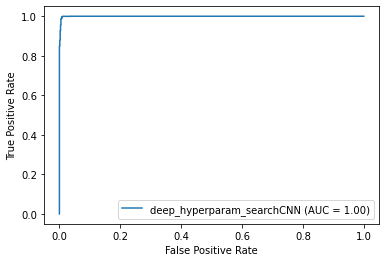

PR auc score 0.9997826287331985


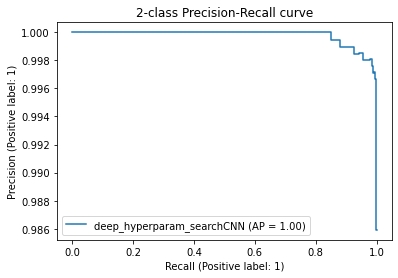

In [12]:
y_proba_loaded = loaded_net.predict_proba(xtest)
compute_metrics(ytest, y_proba_loaded, name=EXPERIMENT_TYPE + "CNN")
